In [1]:
import pandas as pd
import geopandas as gpd
import maup
import time
from maup import smart_repair
from gerrychain import Graph

maup.progress.enabled = True

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Florida
state_ab = "fl"

## Data
1. Download all the data in directory "fl_data"
2. Extract them all

In [5]:
data_folder = state_ab + "_data/"
population1_data = "./{}{}_pl2020_b/{}_pl2020_p1_b.shp".format(data_folder, state_ab, state_ab)
population2_data = "./{}{}_pl2020_b/{}_pl2020_p2_b.shp".format(data_folder, state_ab, state_ab)
vap_data =  "./{}{}_pl2020_b/{}_pl2020_p4_b.shp".format(data_folder, state_ab, state_ab)
vest20_data = "./{}{}_vest_20/{}_vest_20.shp".format(data_folder, state_ab, state_ab)
vest18_data = "./{}{}_vest_18/{}_vest_18.shp".format(data_folder, state_ab, state_ab)
vest16_data = "./{}{}_vest_16/{}_vest_16.shp".format(data_folder, state_ab, state_ab)
cd_data = "./{}{}_cong_adopted_2022/P000C0109.shp".format(data_folder, state_ab)
send_data = "./{}{}_sldu_adopted_2022/S027S8058.shp".format(data_folder, state_ab)
hdist_data = "./{}{}_sldl_adopted_2022/H000H8013.shp".format(data_folder, state_ab)
county_data = "./{}{}_pl2020_cnty/{}_pl2020_cnty.shp".format(data_folder, state_ab, state_ab)

In [6]:
def do_smart_repair(df, min_rook_length = None, snap_precision = 8):
    # change it to the UTM it needs for smart_repair
    df = df.to_crs(df.estimate_utm_crs())
    df = smart_repair(df, min_rook_length = min_rook_length, snap_precision=snap_precision)

    if maup.doctor(df) == False:
        print("maup doctor failed!  Please investigate")
        #raise Exception('maup.doctor failed')
    
    return df

In [7]:
def add_district(dist_df, dist_name, election_df, col_name):
    election_df = election_df.to_crs(election_df.estimate_utm_crs())
    dist_df = dist_df.to_crs(dist_df.estimate_utm_crs())
    # check if it needs to be smart_repair
    if maup.doctor(dist_df) != True:
        dist_df = do_smart_repair(dist_df)

    # assign the pricincts
    precincts_to_district_assignment = maup.assign(election_df.geometry, dist_df.geometry)
    election_df[dist_name] = precincts_to_district_assignment
    for precinct_index in range(len(election_df)):
        election_df.at[precinct_index, dist_name] = dist_df.at[election_df.at[precinct_index, dist_name], col_name]

    return election_df

In [8]:
def rename(original, year):
    party = original[6]
    if party == 'R' or party == 'D':
        return original[3:6] + year + original[6]
    else:
        return original[3:6] + year + 'O'

In [9]:
pop_col = ['TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP']

In [10]:
def check_population(population, df):
    pop_check = pd.DataFrame({
        'pop_col': pop_col,
        'population_df': population[pop_col].sum(), 
        'vest_base': df[pop_col].sum(),
        'equal': [x == y for x, y in zip(population[pop_col].sum(), df[pop_col].sum())]
    })
    if pop_check['equal'].mean() < 1:
        print(pop_check)
        raise Exception("population doesn't agree")

    else:
        print("population agrees")

In [11]:
def add_vest(vest, df, year, population, start_col, snap_precision = 8):
    df = df.to_crs(df.estimate_utm_crs())
    vest = vest.to_crs(vest.estimate_utm_crs())
    population = population.to_crs(population.estimate_utm_crs())
    df_crs = df.crs
    vest_crs = vest.crs
    
     # check if it needs to be smart_repair
    if maup.doctor(vest) != True:
        vest = do_smart_repair(vest, snap_precision = snap_precision)
    
    # rename the columns
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum() # combine all the other party's vote into columns with sufix "O"
    col_name = list(set(new_col))
    col_name.sort()
    
    # make the blocks from precincts by weight
    vest = gpd.GeoDataFrame(vest, crs=vest_crs)
    election_in_block = population[["VAP", 'geometry']] # population_df is in block scale
    blocks_to_precincts_assignment = maup.assign(election_in_block.geometry, vest.geometry)
    weights = election_in_block["VAP"] / blocks_to_precincts_assignment.map(election_in_block["VAP"].groupby(blocks_to_precincts_assignment).sum())
    weights = weights.fillna(0)
    prorated = maup.prorate(blocks_to_precincts_assignment, vest[col_name], weights)
    election_in_block[col_name] = prorated
    
    # assign blocks to precincts
    election_in_block = gpd.GeoDataFrame(election_in_block, crs=vest_crs)
    df = gpd.GeoDataFrame(df, crs=df_crs)
    block_to_pricinct_assginment = maup.assign(election_in_block.geometry, df.geometry)
    df[col_name] = election_in_block[col_name].groupby(block_to_pricinct_assginment).sum()
    df = df.groupby(level=0, axis=1).sum()
    df = gpd.GeoDataFrame(df, crs = df_crs)
    # check if population agrees
    check_population(population, df)
    
    return df

In [12]:
def add_vest_base(vest, start_col, year, county = None, min_rook_length = None, snap_precision = 8):
    vest = vest.to_crs(vest.estimate_utm_crs())
    vest_crs = vest.crs
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum()
    vest = gpd.GeoDataFrame(vest, crs=vest_crs)

    if county is not None:
        county = county.to_crs(county.estimate_utm_crs())
        vest = smart_repair(vest, nest_within_regions = county, min_rook_length = min_rook_length, snap_precision = snap_precision) # nest precincts within counties

    else:
        vest = smart_repair(vest, min_rook_length = min_rook_length, snap_precision = snap_precision) 
    
    return vest

In [13]:
def check_small_boundary_lengths(vest_base):
    import copy
    vest_base = vest_base.to_crs(vest_base.estimate_utm_crs())

    boundaries = copy.deepcopy(vest_base)
    boundaries["geometry"] = boundaries.geometry.boundary  # get boundaries
    neighbors = gpd.sjoin(boundaries, vest_base, predicate="intersects") # find boundaries that intersect
    neighbors = neighbors[neighbors.index != neighbors.index_right] # remove boundaries of a region with itself

    # compute shared border length using intersection
    borders = list(neighbors.apply(
        lambda row: row.geometry.intersection(vest_base.loc[row.index_right, "geometry"]).length, axis=1
    ))

    borders.sort()
    
    return borders

### Read the census data

In [15]:
population1_df = gpd.read_file(population1_data)
population2_df = gpd.read_file(population2_data)
vap_df = gpd.read_file(vap_data)
county_df = gpd.read_file(county_data)

In [16]:
population2_df = population2_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])
vap_df = vap_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])

In [17]:
population_df = pd.merge(population1_df, population2_df, on='GEOID20')
population_df = pd.merge(population_df, vap_df, on='GEOID20')
population_df = population_df.to_crs(population_df.estimate_utm_crs())

In [18]:
maup.doctor(population_df)

100%|█████████████████████████████████| 390066/390066 [02:05<00:00, 3119.44it/s]


True

In [19]:
population_df['H_WHITE'] = population_df.apply(lambda t: t['P0010003'] - t['P0020005'], 1)
population_df['H_BLACK'] = population_df.apply(lambda t: t['P0010004'] - t['P0020006'], 1)
population_df['H_AMIN'] = population_df.apply(lambda t: t['P0010005'] - t['P0020007'], 1)
population_df['H_ASIAN'] = population_df.apply(lambda t: t['P0010006'] - t['P0020008'], 1)
population_df['H_NHPI'] = population_df.apply(lambda t: t['P0010007'] - t['P0020009'], 1)
population_df['H_OTHER'] = population_df.apply(lambda t: t['P0010008'] - t['P0020010'], 1)
population_df['H_2MORE'] = population_df.apply(lambda t: t['P0010009'] - t['P0020011'], 1)

In [20]:
rename_dict = {'P0020001': 'TOTPOP', 'P0020002': 'HISP', 'P0020005': 'NH_WHITE', 'P0020006': 'NH_BLACK', 'P0020007': 'NH_AMIN',
                    'P0020008': 'NH_ASIAN', 'P0020009': 'NH_NHPI', 'P0020010': 'NH_OTHER', 'P0020011': 'NH_2MORE',
                    'P0040001': 'VAP', 'P0040002': 'HVAP', 'P0040005': 'WVAP', 'P0040006': 'BVAP', 'P0040007': 'AMINVAP',
                                        'P0040008': 'ASIANVAP', 'P0040009': 'NHPIVAP', 'P0040010': 'OTHERVAP', 'P0040011': '2MOREVAP'}

In [21]:
population_df.rename(columns=rename_dict, inplace = True)

Make sure that the County shapefile is clean:

In [23]:
maup.doctor(county_df)

100%|██████████████████████████████████████████| 67/67 [00:00<00:00, 274.90it/s]


True

## Read the vest 20 data

Now using it as a "base pricinct"

## Check if vest20 can be used as base

In [26]:
vest20 = gpd.read_file(vest20_data)

In [27]:
vest20.columns

Index(['COUNTY', 'PRECINCT', 'PCT_STD', 'G20PRERTRU', 'G20PREDBID',
       'G20PRELJOR', 'G20PREODEL', 'G20PRESLAR', 'G20PREGHAW', 'G20PRECBLA',
       'G20PREOWRI', 'geometry'],
      dtype='object')

In [28]:
start_col = 3
vest_base_data = vest20
year = '20'

In [29]:
vest_base = add_vest_base(vest_base_data, start_col, year, county = county_df)

100%|██████████████████████████████████████████| 67/67 [00:00<00:00, 279.71it/s]


Snapping all geometries to a grid with precision 10^( -3 ) to avoid GEOS errors.


100%|███████████████████████████████████████████| 67/67 [00:00<00:00, 89.60it/s]


Identifying overlaps...


100%|███████████████████████████████████| 36936/36936 [00:32<00:00, 1150.82it/s]


Resolving overlaps and filling gaps...


Gaps to simplify in region 0: 100%|████████████| 41/41 [00:00<00:00, 133.45it/s]
Gaps to fill: 0it [00:00, ?it/s]


1 gaps in region 1 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 1: 100%|███████████████████| 2/2 [00:00<00:00, 47.43it/s]


1 gaps in region 2 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 2: 100%|██████████████| 9/9 [00:00<00:00, 184.54it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to fill in region 3: 100%|█████████████████| 15/15 [00:00<00:00, 38.03it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]


1 gaps in region 7 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 8: 100%|█████████████████| 11/11 [00:00<00:00, 45.36it/s]


1 gaps in region 9 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 9: 100%|███████████████████| 6/6 [00:00<00:00, 15.10it/s]


1 gaps in region 10 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 12: 100%|█████████████| 2/2 [00:00<00:00, 107.70it/s]
Gaps to fill: 0it [00:00, ?it/s]


1 gaps in region 13 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 13: 100%|██████████████████| 1/1 [00:00<00:00, 46.61it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]


2 gaps in region 15 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 16: 100%|██████████████████| 1/1 [00:00<00:00, 32.59it/s]


1 gaps in region 17 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 20: 100%|████████████████| 11/11 [00:00<00:00, 60.17it/s]


1 gaps in region 21 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 21: 758it [00:53, 14.25it/s]                         
Gaps to fill in region 25: 100%|██████████████████| 8/8 [00:00<00:00, 40.93it/s]


1 gaps in region 26 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 26: 100%|██████████████████| 6/6 [00:00<00:00, 32.12it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]


1 gaps in region 28 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 28: 100%|████████████████| 38/38 [00:02<00:00, 16.38it/s]


1 gaps in region 29 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 29: 100%|████████████████| 14/14 [00:00<00:00, 36.29it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]


1 gaps in region 31 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 31: 100%|███████████| 23/23 [00:00<00:00, 150.89it/s]
Gaps to fill: 0it [00:00, ?it/s]


1 gaps in region 32 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 32: 100%|████████████████| 84/84 [00:01<00:00, 80.99it/s]


1 gaps in region 33 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 34: 100%|████████████████| 60/60 [00:01<00:00, 37.14it/s]


3 gaps in region 35 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 35: 100%|████████████████| 60/60 [00:03<00:00, 17.49it/s]


1 gaps in region 36 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 36: 100%|█████████████| 6/6 [00:00<00:00, 163.16it/s]
Gaps to fill: 0it [00:00, ?it/s]


1 gaps in region 37 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 37: 100%|████████████████| 12/12 [00:00<00:00, 22.74it/s]


1 gaps in region 38 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]


1 gaps in region 39 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]


1 gaps in region 40 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 42: 100%|██████████████████| 8/8 [00:00<00:00, 29.54it/s]


1 gaps in region 43 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 44: 100%|████████████████| 19/19 [00:06<00:00,  2.96it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]


1 gaps in region 46 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 47: 100%|██████████████████| 8/8 [00:00<00:00, 19.44it/s]


1 gaps in region 48 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 48: 100%|██████████████████| 1/1 [00:00<00:00, 56.43it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to fill in region 52: 100%|██████████████████| 2/2 [00:00<00:00, 22.25it/s]


1 gaps in region 53 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 54: 100%|███████████| 43/43 [00:00<00:00, 107.67it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to fill in region 55: 100%|████████████████| 41/41 [00:02<00:00, 19.41it/s]


3 gaps in region 56 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 56: 100%|████████████| 16/16 [00:00<00:00, 89.08it/s]
Gaps to fill: 0it [00:00, ?it/s]


1 gaps in region 57 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 57: 100%|██████████████| 2/2 [00:00<00:00, 69.99it/s]
Gaps to fill: 0it [00:00, ?it/s]


1 gaps in region 58 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 59: 100%|██████████████████| 4/4 [00:00<00:00, 42.33it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify in region 61: 100%|██████████| 115/115 [00:01<00:00, 92.83it/s]
Gaps to fill: 0it [00:00, ?it/s]


1 gaps in region 62 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to fill in region 63: 100%|██████████████████| 7/7 [00:00<00:00, 51.29it/s]


1 gaps in region 64 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 64: 100%|███████████| 64/64 [00:00<00:00, 109.69it/s]
Gaps to fill: 0it [00:00, ?it/s]


1 gaps in region 65 will remain unfilled, because they either are not simply connected or exceed the area threshold.


Gaps to simplify in region 65: 100%|████████████| 54/54 [00:01<00:00, 37.74it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]


In [30]:
borders = check_small_boundary_lengths(vest_base)
print(borders[3000:5000])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [31]:
vest_base = do_smart_repair(vest_base, min_rook_length = 30.5, snap_precision=10)

Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|█████████████████████████████████████| 8192/8192 [00:04<00:00, 1739.98it/s]


Resolving overlaps...
4 gaps will remain unfilled, because they either are not simply connected or exceed the area threshold.
Filling gaps...


Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]

Converting small rook adjacencies to queen...



100%|█████████████████████████████████████| 6162/6162 [00:03<00:00, 1567.33it/s]


There are 4 holes.
maup doctor failed!  Please investigate


In [32]:
maup.doctor(vest_base)

100%|█████████████████████████████████████| 6162/6162 [00:04<00:00, 1523.96it/s]


There are 4 holes.


False

## If it is true for maup doctor, we will use it as the base vest data.

In [34]:
# vap and population have the same GEOID20
blocks_to_precincts_assignment = maup.assign(population_df.geometry, vest_base.geometry)

100%|██████████████████████████████████████| 6162/6162 [00:22<00:00, 279.96it/s]


In [35]:
vest_base[pop_col] = population_df[pop_col].groupby(blocks_to_precincts_assignment).sum()

In [36]:
election_df = gpd.GeoDataFrame(vest_base)

In [37]:
election_df.columns

Index(['COUNTY', 'PCT_STD', 'PRE20D', 'PRE20O', 'PRE20R', 'PRECINCT',
       'geometry', 'TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN',
       'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'H_WHITE', 'H_BLACK',
       'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP',
       'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP',
       '2MOREVAP'],
      dtype='object')

## Check if population agrees

In [39]:
check_population(population_df, vest_base)

population agrees


## Add more vest data

In [41]:
vest18 = gpd.read_file(vest18_data)
vest16 = gpd.read_file(vest16_data)

In [42]:
vest18.columns

Index(['COUNTY', 'PRECINCT', 'PCT_STD', 'G18USSRSCO', 'G18USSDNEL',
       'G18USSOWRI', 'G18GOVRDES', 'G18GOVDGIL', 'G18GOVORIC', 'G18GOVNGIB',
       'G18GOVNFOL', 'G18GOVNSTA', 'G18GOVOWRI', 'G18ATGRMOO', 'G18ATGDSHA',
       'G18ATGNSIS', 'G18CFORPAT', 'G18CFODRIN', 'G18CFOOWRI', 'G18AGRRCAL',
       'G18AGRDFRI', 'geometry'],
      dtype='object')

In [43]:
vest16.columns

Index(['COUNTY', 'PRECINCT', 'PCT_STD', 'G16PRERTRU', 'G16PREDCLI',
       'G16PRELJOH', 'G16PRECCAS', 'G16PREGSTE', 'G16PREODEL', 'G16PREOWRI',
       'G16USSRRUB', 'G16USSDMUR', 'G16USSLSTA', 'G16USSNKHO', 'G16USSNNAT',
       'G16USSNMAC', 'G16USSNDAL', 'G16USSOWRI', 'geometry'],
      dtype='object')

In [44]:
election_df = smart_repair(election_df, min_rook_length = 30.5, snap_precision=8)

Snapping all geometries to a grid with precision 10^( -3 ) to avoid GEOS errors.
Identifying overlaps...


100%|█████████████████████████████████████| 8201/8201 [00:04<00:00, 1736.49it/s]


Resolving overlaps...
Assigning order 2 pieces...
Assigning order 3 pieces...
4 gaps will remain unfilled, because they either are not simply connected or exceed the area threshold.
Filling gaps...


Gaps to simplify: 100%|███████████████████████████| 1/1 [00:00<00:00,  1.31it/s]
Gaps to fill: 0it [00:00, ?it/s]


Converting small rook adjacencies to queen...


100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 3117.05it/s]


In [45]:
election_df = smart_repair(election_df, min_rook_length = 30.5, snap_precision=8)

Snapping all geometries to a grid with precision 10^( -3 ) to avoid GEOS errors.
Identifying overlaps...


100%|█████████████████████████████████████| 8194/8194 [00:04<00:00, 1747.24it/s]


Resolving overlaps...
4 gaps will remain unfilled, because they either are not simply connected or exceed the area threshold.
Filling gaps...


Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]

Converting small rook adjacencies to queen...



100%|█████████████████████████████████████| 6162/6162 [00:04<00:00, 1473.07it/s]


In [46]:
maup.doctor(election_df)

100%|█████████████████████████████████████| 6162/6162 [00:04<00:00, 1490.40it/s]


There are 4 holes.


False

In [47]:
election_df

,COUNTY,PCT_STD,PRE20D,PRE20O,PRE20R,PRECINCT,geometry,TOTPOP,HISP,NH_WHITE,...,H_2MORE,VAP,HVAP,WVAP,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP
0,BAY,BAY0001,220,15,1330,1,"POLYGON ((68879.777 3376334.096, 68879.193 337...",4062.0,204.0,3447.0,...,90.0,3130.0,131.0,2683.0,26.0,51.0,19.0,0.0,9.0,211.0
1,BAY,BAY0002,132,11,859,2,"POLYGON ((78473.949 3375202.604, 78564.564 337...",1923.0,86.0,1691.0,...,34.0,1547.0,56.0,1387.0,15.0,8.0,3.0,1.0,1.0,76.0
2,BAY,BAY0004,362,33,2130,4,"POLYGON ((70050.677 3361703.828, 70055.737 336...",5282.0,202.0,4665.0,...,74.0,4163.0,151.0,3716.0,57.0,16.0,13.0,1.0,11.0,198.0
3,BAY,BAY0005,324,24,2286,5,"POLYGON ((58807.518 3363318.950, 58819.221 336...",4863.0,230.0,4265.0,...,98.0,3639.0,153.0,3208.0,58.0,22.0,33.0,3.0,3.0,159.0
4,BAY,BAY0006,497,34,2799,6,"POLYGON ((58770.051 3361447.790, 58669.183 336...",5770.0,210.0,5061.0,...,88.0,4579.0,155.0,4059.0,68.0,27.0,32.0,6.0,4.0,228.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6157,OSC,OSC0999,3,0,4,999,"POLYGON ((466692.971 3127956.516, 466662.504 3...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6158,MON,MON0005,1705,52,999,5,"MULTIPOLYGON (((420022.297 2709301.768, 419954...",2408.0,273.0,1909.0,...,136.0,2220.0,215.0,1822.0,84.0,1.0,29.0,1.0,7.0,61.0
6159,MON,MON0999,5,1,10,999,"POLYGON ((418628.480 2715816.774, 418624.770 2...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6160,FLA,FLA0009,1025,23,1569,9,"POLYGON ((478402.651 3255324.547, 478348.409 3...",5091.0,556.0,3661.0,...,200.0,4059.0,396.0,3008.0,395.0,12.0,61.0,1.0,27.0,159.0


In [48]:
# check the result here
election_df = add_vest(vest18, election_df, '18', population_df, start_col)

100%|█████████████████████████████████████| 6152/6152 [00:04<00:00, 1508.80it/s]


There are 2683 overlaps.
There are 13705 holes.
There are some invalid geometries.
Snapping all geometries to a grid with precision 10^( -3 ) to avoid GEOS errors.
Identifying overlaps...


100%|███████████████████████████████████| 26504/26504 [00:14<00:00, 1799.85it/s]


Resolving overlaps...
Assigning order 2 pieces...
Assigning order 3 pieces...
4 gaps will remain unfilled, because they either are not simply connected or exceed the area threshold.
Filling gaps...


Gaps to simplify: 8658it [2:00:25,  1.20it/s]                                   
100%|█████████████████████████████████████| 6152/6152 [00:05<00:00, 1209.09it/s]


There are 4 holes.
maup doctor failed!  Please investigate


100%|██████████████████████████████████████| 6162/6162 [00:21<00:00, 288.33it/s]


population agrees


In [49]:
election_df.columns

Index(['2MOREVAP', 'AGR18D', 'AGR18R', 'AMINVAP', 'ASIANVAP', 'ATG18D',
       'ATG18O', 'ATG18R', 'BVAP', 'CFO18D', 'CFO18O', 'CFO18R', 'COUNTY',
       'GOV18D', 'GOV18O', 'GOV18R', 'HISP', 'HVAP', 'H_2MORE', 'H_AMIN',
       'H_ASIAN', 'H_BLACK', 'H_NHPI', 'H_OTHER', 'H_WHITE', 'NHPIVAP',
       'NH_2MORE', 'NH_AMIN', 'NH_ASIAN', 'NH_BLACK', 'NH_NHPI', 'NH_OTHER',
       'NH_WHITE', 'OTHERVAP', 'PCT_STD', 'PRE20D', 'PRE20O', 'PRE20R',
       'PRECINCT', 'TOTPOP', 'USS18D', 'USS18O', 'USS18R', 'VAP', 'WVAP',
       'geometry'],
      dtype='object')

In [50]:
election_df = add_vest(vest16, election_df, '16', population_df, start_col)

100%|█████████████████████████████████████| 6116/6116 [00:04<00:00, 1455.86it/s]


There are 2331 overlaps.
There are 13008 holes.
There are some invalid geometries.
Snapping all geometries to a grid with precision 10^( -3 ) to avoid GEOS errors.
Identifying overlaps...


100%|███████████████████████████████████| 24599/24599 [00:12<00:00, 2040.26it/s]


Resolving overlaps...
Assigning order 2 pieces...
Assigning order 3 pieces...
5 gaps will remain unfilled, because they either are not simply connected or exceed the area threshold.
Filling gaps...


Gaps to simplify: 7783it [1:46:42,  1.22it/s]                                   
Gaps to fill: 100%|███████████████████████████| 547/547 [15:51<00:00,  1.74s/it]


100%|█████████████████████████████████████| 6116/6116 [00:04<00:00, 1519.38it/s]


There are 5 holes.
maup doctor failed!  Please investigate


100%|██████████████████████████████████████| 6162/6162 [00:19<00:00, 319.11it/s]


population agrees


In [51]:
election_df = smart_repair(election_df, snap_precision=8)

Snapping all geometries to a grid with precision 10^( -3 ) to avoid GEOS errors.
Identifying overlaps...


100%|█████████████████████████████████████| 8194/8194 [00:04<00:00, 1795.03it/s]


Resolving overlaps...
4 gaps will remain unfilled, because they either are not simply connected or exceed the area threshold.
Filling gaps...


Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]


##  Add the district data

In [53]:
cong_df = gpd.read_file(cd_data)
cong_df = cong_df.to_crs(cong_df.estimate_utm_crs())
send = gpd.read_file(send_data)
send = send.to_crs(send.estimate_utm_crs())
hdist = gpd.read_file(hdist_data)
hdist = hdist.to_crs(hdist.estimate_utm_crs())

In [54]:
cong_df.head()

,LONGNAME,SHORTNAME,DISTRICT,COLOR,TOTAL,TARGET_DEV,geometry
0,District 1,D1,1,-190427942,769221,0,"POLYGON ((-52798.886 3443672.228, -52073.607 3..."
1,District 2,D2,2,-112762508,769221,0,"POLYGON ((6801.621 3411477.544, 6805.621 34115..."
2,District 3,D3,3,-116800934,769221,0,"POLYGON ((291403.592 3363472.821, 291397.795 3..."
3,District 4,D4,4,329774720,769221,0,"POLYGON ((399079.077 3349550.980, 399074.104 3..."
4,District 5,D5,5,-9183360,769221,0,"POLYGON ((469197.125 3346855.478, 469345.109 3..."


In [55]:
election_df = add_district(cong_df, "CD", election_df, "DISTRICT")

100%|███████████████████████████████████████████| 28/28 [00:00<00:00, 69.37it/s]


In [56]:
send.head()

,LONGNAME,SHORTNAME,DISTRICT,COLOR,TOTAL,TARGET_DEV,SRWVAP,SRWVAP_P,NHBVAP,NHBVAP_P,...,HBVAP_P,HXBVAP,HXBVAP_P,OTHVAP,OTHVAP_P,BVAP,BVAP_P,HVAP,HVAP_P,geometry
0,District 1,D1,1,-192953100,539263,0.15,302734,71.21,64925,15.27,...,0.35,22701,5.34,33265,7.82,66429,15.63,24205,5.69,"POLYGON ((-88962.543 3445849.842, -88951.994 3..."
1,District 2,D2,2,-38041984,538769,0.06,320663,75.05,46676,10.92,...,0.36,28893,6.76,29479,6.90,48210,11.28,30427,7.12,"POLYGON ((77275.266 3349211.655, 77243.849 334..."
2,District 3,D3,3,-104031936,541142,0.50,266964,61.09,117678,26.93,...,0.51,28626,6.55,21549,4.93,119888,27.43,30836,7.06,"POLYGON ((211848.311 3397126.994, 211854.147 3..."
3,District 4,D4,4,-45696,542508,0.75,298014,68.65,55786,12.85,...,0.69,36892,8.50,40415,9.31,58760,13.54,39866,9.18,"POLYGON ((455436.438 3397695.867, 455463.032 3..."
4,District 5,D5,5,-895104640,543411,0.92,177567,42.31,170244,40.56,...,1.06,39314,9.37,28142,6.71,174685,41.62,43755,10.43,"POLYGON ((420484.584 3339989.321, 420432.398 3..."


In [57]:
election_df = add_district(send, "SEND", election_df, "DISTRICT")

100%|███████████████████████████████████████████| 40/40 [00:00<00:00, 84.15it/s]


In [58]:
hdist.head()

,LONGNAME,SHORTNAME,DISTRICT,COLOR,TOTAL,TARGET_DEV,SRWVAP,SRWVAP_P,NHBVAP,NHBVAP_P,...,HBVAP_P,HXBVAP,HXBVAP_P,OTHVAP,OTHVAP_P,BVAP,BVAP_P,HVAP,HVAP_P,geometry
0,District 1,D1,1,-192953100,178511,-0.54,92944,65.64,29389,20.76,...,0.36,7121,5.03,11624,8.21,29899,21.12,7631,5.39,"POLYGON ((-93306.111 3395452.273, -93267.058 3..."
1,District 2,D2,2,-38041984,180797,0.73,101968,69.98,24078,16.53,...,0.34,8258,5.67,10898,7.48,24577,16.87,8757,6.01,"POLYGON ((-85131.854 3380393.092, -84724.200 3..."
2,District 3,D3,3,-104031936,178528,-0.53,109163,79.52,10128,7.38,...,0.31,7019,5.11,10547,7.68,10553,7.69,7444,5.42,"POLYGON ((-57326.955 3380861.500, -57327.349 3..."
3,District 4,D4,4,-45696,183737,2.37,100925,70.47,15181,10.60,...,0.60,13047,9.11,13208,9.22,16043,11.20,13909,9.71,"POLYGON ((-32019.954 3420092.279, -32014.099 3..."
4,District 5,D5,5,-895104640,181243,0.98,112362,77.53,18471,12.75,...,0.18,7062,4.87,6762,4.67,18735,12.93,7326,5.06,"POLYGON ((38504.495 3438984.858, 38520.088 343..."


In [59]:
election_df = add_district(hdist, "HDIST", election_df, "DISTRICT")

100%|████████████████████████████████████████| 120/120 [00:00<00:00, 130.88it/s]


In [60]:
maup.doctor(election_df)

100%|█████████████████████████████████████| 6162/6162 [00:04<00:00, 1291.03it/s]


There are 4 holes.


False

### Put the base precinct year after the precinct information column

In [62]:
base_columns = {}
if 'COUNTY' + year not in election_df.columns:
    base_columns = {
        'COUNTY':'COUNTY'+year,
        'PRECINCT':'PRECINCT'+year, 
        'PCT_STD':'PCT_STD'+year
    }
election_df.rename(columns=base_columns, inplace = True)

In [63]:
election_df.columns

Index(['2MOREVAP', 'AGR18D', 'AGR18R', 'AMINVAP', 'ASIANVAP', 'ATG18D',
       'ATG18O', 'ATG18R', 'BVAP', 'CFO18D', 'CFO18O', 'CFO18R', 'COUNTY20',
       'GOV18D', 'GOV18O', 'GOV18R', 'HISP', 'HVAP', 'H_2MORE', 'H_AMIN',
       'H_ASIAN', 'H_BLACK', 'H_NHPI', 'H_OTHER', 'H_WHITE', 'NHPIVAP',
       'NH_2MORE', 'NH_AMIN', 'NH_ASIAN', 'NH_BLACK', 'NH_NHPI', 'NH_OTHER',
       'NH_WHITE', 'OTHERVAP', 'PCT_STD20', 'PRE16D', 'PRE16O', 'PRE16R',
       'PRE20D', 'PRE20O', 'PRE20R', 'PRECINCT20', 'TOTPOP', 'USS16D',
       'USS16O', 'USS16R', 'USS18D', 'USS18O', 'USS18R', 'VAP', 'WVAP',
       'geometry', 'CD', 'SEND', 'HDIST'],
      dtype='object')

In [64]:
# reorder the columns
fixed_columns = [
    'COUNTY'+year,
    'PRECINCT'+year, 
    'PCT_STD'+year,
    'SEND',
    'HDIST',
    'TOTPOP',
    'NH_2MORE',
    'NH_AMIN',
    'NH_ASIAN',
    'NH_BLACK',
    'NH_NHPI',
    'NH_OTHER',
    'NH_WHITE',
    'HISP',
    'H_AMIN',
    'H_ASIAN',
    'H_BLACK',
    'H_NHPI',
    'H_OTHER',
    'H_WHITE',
    'H_2MORE',
    'VAP',
    'HVAP',
    'WVAP',
    'BVAP',
    'AMINVAP',
    'ASIANVAP',
    'NHPIVAP',
    'OTHERVAP',
    '2MOREVAP']

election_columns = [col for col in election_df.columns if col not in fixed_columns]
final_col = fixed_columns + election_columns
election_df = election_df[final_col]

In [65]:
import os

# store the result in directory "fl"
directory = "./{}".format(state_ab)
if not os.path.exists(directory):
    os.makedirs(directory)

shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
geojson_path = './{}/{}.geojson'.format(state_ab, state_ab)
json_path = "./{}.json".format(state_ab, state_ab)

# Check if the shapefile or geojson file already exists
if os.path.exists(shapefile_path):
    os.remove(shapefile_path)
if os.path.exists(geojson_path):
    os.remove(geojson_path)

election_df.to_file(shapefile_path)
election_df.to_file(geojson_path, driver='GeoJSON')

# Only do once to build json and read from file when generating ensembles
graph = Graph.from_file(shapefile_path, ignore_errors=True)
graph.to_json(json_path)

<Axes: >

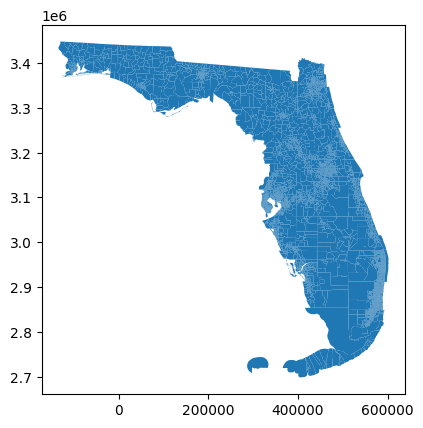

In [66]:
shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
shape=gpd.read_file(shapefile_path)
shape.plot()

In [130]:
election_df.columns

Index(['COUNTY20', 'PRECINCT20', 'PCT_STD20', 'SEND', 'HDIST', 'TOTPOP',
       'NH_2MORE', 'NH_AMIN', 'NH_ASIAN', 'NH_BLACK', 'NH_NHPI', 'NH_OTHER',
       'NH_WHITE', 'HISP', 'H_AMIN', 'H_ASIAN', 'H_BLACK', 'H_NHPI', 'H_OTHER',
       'H_WHITE', 'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP',
       'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP', 'AGR18D', 'AGR18R',
       'ATG18D', 'ATG18O', 'ATG18R', 'CFO18D', 'CFO18O', 'CFO18R', 'GOV18D',
       'GOV18O', 'GOV18R', 'PRE16D', 'PRE16O', 'PRE16R', 'PRE20D', 'PRE20O',
       'PRE20R', 'USS16D', 'USS16O', 'USS16R', 'USS18D', 'USS18O', 'USS18R',
       'geometry', 'CD'],
      dtype='object')

In [132]:
len(election_df.columns)

55